In [1]:
# run in one batch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# define cleaning functions
def clean_q_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe, series, series
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    
    # annual peak Q
    annual_peak_q = q_df.groupby(q_df.year)['cfs'].max()

#     # cumulative Q
#     sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()
#     sum_q_df = pd.DataFrame(q_df.year,sum_q).reset_index()
#     annual_sum_q = sum_q_df.groupby(sum_q_df.year)['cfs'].max()

    return(daily_q_df, annual_peak_q)

def clean_snow_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['dt_string'])
    snow_df['year'] = snow_df['dt'].dt.year

    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    
    # annual peak swe
    annual_peak_swe = snow_df.groupby(snow_df.year)['swe_start_m'].max()
    
    # annual cumulative swe
    cumsum_swe = snow_df.groupby(snow_df['year'])['swe_start_m'].cumsum()
    
    #cumsum_swe.reindex(snow_df.year)
    #cumsum_swe_df = pd.DataFrame(grp_year,cumsum_swe)
    #cumsum_swe_df.set_index(snow_df['year'])
    #annual_sum_swe = cumsum_swe_df.groupby(snow_df['year'])['swe_start_m'].max()
    
    return(snow_df, annual_peak_swe, cumsum_swe)

def clean_outliers(df):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [3]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df, annual_peak_q = clean_q_data_annual(q_df)

# annual sum q
annual_cumsum_q = daily_q_df.groupby(daily_q_df.index.year)['cfs'].cumsum()
annual_sum_q = annual_cumsum_q.groupby(annual_cumsum_q.index.year).max()

In [4]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass','682_park_reservoir',
                '669_north_lost_trail','1059_cochetopa_pass']
data_lst = []
count = 0
peakswe_lst = []
sumswe_lst = []
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['dt_string', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    # clean snow data
    snow_df, annual_peak_swe, cumsum_swe = clean_snow_data_annual(snow_df)
    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    peakswe_lst.append(annual_peak_swe)
    sumswe_lst.append(cumsum_swe)
    count += 1
print(count)
# peak swe for each station
data_df = pd.concat(data_lst, axis=0, ignore_index = True)
peakswe_df = pd.concat(peakswe_lst,axis=1)
peakswe_df.columns = stationnames
# cumsum swe for each station
cumsum_swe_df = pd.concat(sumswe_lst,axis=1)
cumsum_swe_df.columns = stationnames
# max sum swe by year for each station
cumsum_swe_df['year'] = cumsum_swe_df.index.year
sum_list = []
for name in stationnames:
    sum_list.append(cumsum_swe_df.groupby(cumsum_swe_df.year)[name].max())
sumswe_df = pd.concat(sum_list,axis=1)
sumswe_df.columns = stationnames

7


In [5]:
# merge q and swe data
data_x = pd.merge(sumswe_df,peakswe_df, how='left', left_index=True, right_index=True)
data_xy = pd.concat((data_x,annual_peak_q,annual_sum_q),axis=1)

# new columns
cols_new = ['680_sumswe','762_sumswe','701_sumswe','737_sumswe','682_sumswe',
                '669_sumswe','1059_sumswe','680_peakswe','762_peakswe','701_peakswe','737_peakswe','682_peakswe',
                '669_peakswe','1059_peakswe','peak_q','sum_q']
data_xy.columns = cols_new

# clean data matrix
data_xy.drop(data_xy[data_xy.index < 1985].index, inplace=True)

# impute nans instead of remove
data_xy_impute = data_xy.fillna(0)

# drop nans
# data_xy_clean = data_xy.dropna()


In [7]:
#data_xy_impute.head(41)

In [9]:
# prep data for model
model_df = data_xy_impute
cols = model_df.columns
# regression
X = model_df[cols[:-2]]
y = model_df[cols[-1]] # -2 is peak q, -1 is sum q



In [10]:
# make and fit model
degree = 2
#model = make_pipeline(PolynomialFeatures(degree), Ridge());
model = Lasso()
model.fit(X, y);
y_hat = model.predict(X)
# R2 score
score = model.score(X,y)
print('R2 = {0:.3f}'.format(score))

coefs = model.coef_
print(coefs)


R2 = 0.889
[-2.66515645e+04 -3.89681962e+01  1.76332851e+04  6.03270425e+03
 -8.04676855e+03  6.16372353e+03 -2.23243332e+04  3.75510210e+06
  9.82847666e+05 -1.37543973e+06 -6.44606470e+05  8.83994627e+05
 -2.66554616e+05  2.33586782e+06]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
# coefficient matrix
# D = {}
# for idx, name in enumerate(stationnames):
#     D[name] = [[x for x in coefs[idx]], [y for y in coefs[idx+7]]]
# #print(D)

# import csv
# #write to file:
# with open('gunnison_coefs_peak_q.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     for k, v in D.items():
#        writer.writerow([k,v])

sumswe_df.head()

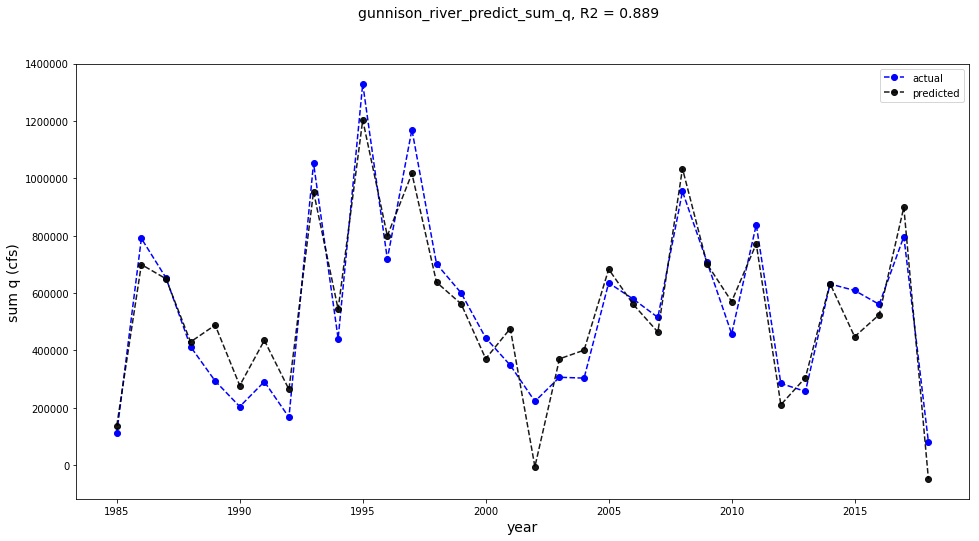

In [12]:
# plot predictions
# plots swe A, B
df = model_df # dataframe to plot from
y # already made
y_hat # already made
figname = 'gunnison_river_predict_sum_q'

# plot
fig, ax = plt.subplots(1,1,figsize=(16,8));
ax.plot(y.index,y,'bo--')
ax.set_ylabel('sum q (cfs)', fontsize=14);
ax.set_xlabel('year', fontsize=14)
ax.plot(y.index,y_hat,'ko--',alpha=0.9)
ax.legend(['actual','predicted'])
plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# arrs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
# for x, col in enumerate(cols[:-1]):
#     ax[arrs[x]].plot(df[col].values,y,'bo')
#     ax[arrs[x]].set_ylabel('q (cfs)');
#     ax[arrs[x]].set_xlabel(cols[x])
#     ax[arrs[x]].plot(df[col].values,y_hat,'ko')
#     ax[arrs[x]].legend(['actual','predicted'])
# plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# save fig
fig.set_size_inches(16, 8)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)

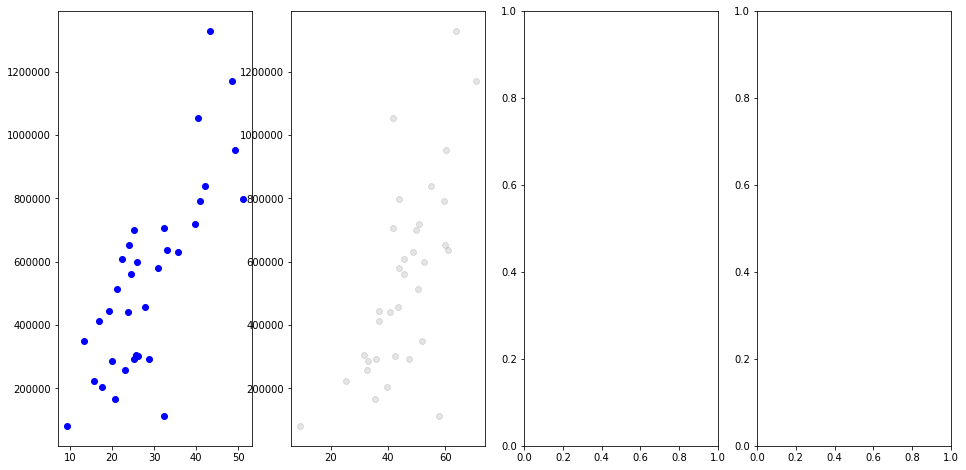

In [13]:
# # explore X,y
# fig, ax = plt.subplots(1,4,figsize=(16,8));
# ax[0].plot(X[cols[0]],y,'bo')
# #ax[0].set_ylabel('q (cfs)');
# #ax.set_xlabel(cols[x])
# ax[1].plot(X[cols[1]],y,'ko',alpha=0.1)
# #ax.legend(['actual','predicted'])